In [ ]:
#all_slow

# Tutorial: Fine-Tuning a Language Model on Text Files with IMDB
> Tuning a base Language model on the IMDB dataset

## Introduction

In this tutorial we will be showing an end-to-end example of fine-tuning a Transformer language model on a custom dataset in text files format.

By the end of this you should be able to:

1. Build a dataset with the `LanguageModelDatasets` class, and their DataLoaders
2. Build a `LanguageModelTuner` quickly, find a good learning rate, and train with the One-Cycle Policy
3. Save that model away, to be used with deployment or other HuggingFace libraries
4. Apply inference using both the `Tuner` available function as well as with the `EasyTextGenerator` class within AdaptNLP

## Installing the Library

This tutorial utilizies the latest AdaptNLP version, as well as parts of the `fastai` library. Please run the below code to install them:

In [ ]:
# !git+https://github.com/novetta/adaptnlp@dev -U

In [ ]:
#hide
from nbverbose.showdoc import *

## Getting the Dataset

First we need a dataset. We will use the `fastai` library to download the full `IMDB` Movie Reviews dataset

In [ ]:
from fastai.data.external import URLs, untar_data

`URLs` holds a namespace of many data endpoints, and `untar_data` is a function that can download and extract any data from a given URL.

Combining both, we can download the data:

In [ ]:
data_path = untar_data(URLs.IMDB)

If we look at what was downloaded, we will find a `train` and `test` folder:

In [ ]:
data_path.ls()

(#7) [Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/tmp_clas'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/tmp_lm')]

In each are folders seperating each text file by class:

In [ ]:
(data_path/'train').ls()

(#4) [Path('/root/.fastai/data/imdb/train/pos'),Path('/root/.fastai/data/imdb/train/neg'),Path('/root/.fastai/data/imdb/train/unsupBow.feat'),Path('/root/.fastai/data/imdb/train/labeledBow.feat')]

As a result, we can say the dataset follows the following format:

- `train`
  - `class_a`
    - `text1.txt`
    - `text2.txt`
    - ...
  - `class_b`
    - `text1.txt`
    - ...
- `test` (or `valid`)
  - `class_a`
    - `text1.txt`
    - ...
  - `class_b`
    - `text1.txt`
    - ...

> Note: In this instance, test and validation have very similar meanings. Both are the dataset which is used to calculate the metrics during training (such as accuracy or F1Score)

Now that we have the dataset, and we know the format it is in, let's pick a viable model to train with

## Picking a Model with the Hub

AdaptNLP has a `HFModelHub` class that allows you to communicate with the HuggingFace Hub and pick a model from it, as well as a namespace `HF_TASKS` class with a list of valid tasks we can search by.

Let's try and find one suitable for sequence classification.

First we need to import the class and generate an instance of it:

In [ ]:
from adaptnlp import HFModelHub, HF_TASKS

In [ ]:
hub = HFModelHub()

Next we can search for a model:

In [ ]:
models = hub.search_model_by_task(HF_TASKS.TEXT_GENERATION)

Let's look at a few:

In [ ]:
models[:10]

[Model Name: distilgpt2, Tasks: [text-generation],
 Model Name: gpt2-large, Tasks: [text-generation],
 Model Name: gpt2-medium, Tasks: [text-generation],
 Model Name: gpt2-xl, Tasks: [text-generation],
 Model Name: gpt2, Tasks: [text-generation],
 Model Name: openai-gpt, Tasks: [text-generation],
 Model Name: transfo-xl-wt103, Tasks: [text-generation],
 Model Name: xlnet-base-cased, Tasks: [text-generation],
 Model Name: xlnet-large-cased, Tasks: [text-generation]]

These are models specifically tagged with the `text-generation` tag, so you may not see a few models you would expect such as `bert_base_cased`.

We'll use that first model, `distilgpt2`:

In [ ]:
model = models[0]

In [ ]:
model

Model Name: distilgpt2, Tasks: [text-generation]

Now that we have picked a model, let's use the data API to prepare our data

> Note: It should be mentioned that this is optional, you can always just pass in the string name of a model such as "bert-base-cased"

## Building `TaskDatasets` with `LanguageModelDatasets`

Each task has a high-level data wrapper around the `TaskDatasets` class. In our case this is the `LanguageModelDatasets` class:

In [ ]:
from adaptnlp import LanguageModelDatasets

There are multiple different constructors for the `LanguageModelDatasets` class, and you should never call the main constructor directly.

We will be using `from_folders` method:

In [ ]:
from adaptnlp import LanguageModelDatasets
show_doc(LanguageModelDatasets.from_folders)

<h4 id="LanguageModelDatasets.from_folders" class="doc_header"><code>LanguageModelDatasets.from_folders</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/language_model.py#L158" class="source_link" style="float:right">[source]</a></h4>

> <code>LanguageModelDatasets.from_folders</code>(**`train_path`**:`Path`, **`tokenizer_name`**:`str`, **`block_size`**:`int`=*`128`*, **`masked_lm`**:`bool`=*`False`*, **`valid_path`**:`Path`=*`None`*, **`split_func`**:`callable`=*`None`*, **`split_pct`**:`float`=*`0.1`*, **`tokenize_kwargs`**:`dict`=*`{}`*, **`auto_kwargs`**:`dict`=*`{}`*)

Builds [`LanguageModelDatasets`](/adaptnlp/training.language_model.html#LanguageModelDatasets) from a folder or group of folders

**Function Arguments**:
* `train_path` (`Path`): The path to the training data
* `tokenizer_name` (`str`): The name of the tokenizer
* `block_size` (`int`): The size of each block
* `masked_lm` (`bool`): Whether the language model is a MLM
* `valid_path` (`Path`): An optional validation path
* `split_func` (`callable`): Optionally a splitting function similar to RandomSplitter
* `split_pct` (`float`): What % to split the df between training and validation
* `tokenize_kwargs` (`dict`): kwargs for the tokenize function
* `auto_kwargs` (`dict`): kwargs for the AutoTokenizer.from_pretrained constructor


Anything you would normally pass to the tokenizer call (such as `max_length`, `padding`) should go in `tokenize_kwargs`, and anything going to the `AutoTokenizer.from_pretrained` constructor should be passed to the `auto_kwargs`.

In our case we have a `train_path` and `valid_path`

In [ ]:
from fastcore.basics import patch

Also, we will set a block_size of 128, and it is *not* a masked language model:

In [ ]:
dsets = LanguageModelDatasets.from_folders(
    train_path=data_path/'train',
    valid_path=data_path/'test',
    tokenizer_name=model.name,
    block_size=128,
    masked_lm=False
)

Using custom data configuration default-1f2b71eec4880b46
Reusing dataset text_no_new_line (/root/.cache/huggingface/datasets/text_no_new_line/default-1f2b71eec4880b46/0.0.0)
Using custom data configuration default-04d8fbd2bd2108a0
Reusing dataset text_no_new_line (/root/.cache/huggingface/datasets/text_no_new_line/default-04d8fbd2bd2108a0/0.0.0)


No value for `max_length` set, automatically adjusting to the size of the model and including truncation
Sequence length set to: 1024


> Note: If you only have a training folder, just pass in a `split_func` or `split_pct` to either have it split the dataset in a custom way, or pass in a percentage to randomly split by

And finally turn it into some `AdaptiveDataLoaders`.

These are just fastai's `DataLoaders` class, but it overrides a few functions to have it work nicely with HuggingFace's `Dataset` class

In [ ]:
show_doc(LanguageModelDatasets.dataloaders)

<h4 id="TaskDatasets.dataloaders" class="doc_header"><code>TaskDatasets.dataloaders</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L246" class="source_link" style="float:right">[source]</a></h4>

> <code>TaskDatasets.dataloaders</code>(**`batch_size`**:`int`=*`8`*, **`shuffle_train`**:`bool`=*`True`*, **`collate_fn`**:`callable`=*`None`*, **`path`**=*`'.'`*, **`device`**=*`None`*)

Creates `DataLoaders` from the dataset

**Function Arguments**:
* `batch_size` (`int`): A batch size
* `shuffle_train` (`bool`): Whether to shuffle the training dataset
* `collate_fn` (`callable `): A custom collation function


In [ ]:
dls = dsets.dataloaders(batch_size=8)

Finally, let's view a batch of data with the `show_batch` function:

In [ ]:
dls.show_batch()

,Input,Label
0,"dad.""<br /><br />This film makes periodic appearances on TV but today my teenage son and I saw it in a theater with quite a few youngsters present. It was great to see computer-besotted kids in an affluent community respond with cheers and applause to special effects that must seem primitive to them.<br /><br />""Thief of Bagdad"" is a pre-war Hollywood classic from a time when strong production values often resulted in enduringly attractive and important releases. This is one of the best of its kind.<br /><br />9/10.This movie is simply incredible! I had expected something quite different form the film that I actually saw. However, it is very insightful in that it shows the aggressive nature of human sexuality and its linkage with animal behavior. Let me warn those among the readers of this article who are easily offended by content that is all too sexual, for the explicit sexual nature of this film feels like a high-brow sort of pornography. It even features a scene that comes extremely close to rape.<br /><br />Meanwhile, I strongly suggest seeing this rare work of ""sexual art"". Every minute of the picture breathes the sexual spirit of the seventies, by the way. One should not forget how times have changed!<br /><br />Go see it! It´s worth your money and time!If you have ever read and enjoyed a novel by Tom Robbins you will appreciate this movie as a whole-hearted attempt to translate his outrageously unconventional writing style into a workable piece of big screen art. The actors and the direction of this film are both good. <br /><br />The only trouble with the film, as I can see it, is that Robbins can relate ideas and sentiments with his words that were still beyond Hollywood's capabilities at the time this film was shot.<br /><br />Given both the irreverence of today's movies, as well as the willingness and abilityof today's audiences to delve into the bizarre, I think ""Even Cowgirls... would receive a better reception today than it did when it was originally released.With Iphigenia, Mikhali Cacoyannis is perhaps the first film director to have successfully brought the feel of ancient Greek theatre to the screen. His own screenplay, an adaptation of Euripides' tragedy, was far from easy, compared to that of the other two films of the trilogy he directed. The story has been very carefully deconstructed from Euripides' version and","dad.""<br /><br />This film makes periodic appearances on TV but today my teenage son and I saw it in a theater with quite a few youngsters present. It was great to see computer-besotted kids in an affluent community respond with cheers and applause to special effects that must seem primitive to them.<br /><br />""Thief of Bagdad"" is a pre-war Hollywood classic from a time when strong production values often resulted in enduringly attractive and important releases. This is one of the best of its kind.<br /><br />9/10.This movie is simply incredible! I had expected something quite different form the film that I actually saw. However, it is very insightful in that it shows the aggressive nature of human sexuality and its linkage with animal behavior. Let me warn those among the readers of this article who are easily offended by content that is all too sexual, for the explicit sexual nature of this film feels like a high-brow sort of pornography. It even features a scene that comes extremely close to rape.<br /><br />Meanwhile, I strongly suggest seeing this rare work of ""sexual art"". Every minute of the picture breathes the sexual spirit of the seventies, by the way. One should not forget how times have changed!<br /><br />Go see it! It´s worth your money and time!If you have ever read and enjoyed a novel by Tom Robbins you will appreciate this movie as a whole-hearted attempt to translate his outrageously unconventional writing style into a workable piece of big screen art. The actors and the direction of this film are both good. <br /><br />The only trouble with the fil

When training a language model, the input and output are made to be the exact same, so there isn't a shown noticable difference here.

## Building `Tuner`

Next we need to build a compatible `Tuner` for our problem. These tuners contain good defaults for our problem space, including loss functions and metrics.

First let's import the `LanguageModelTuner` and view it's documentation

In [ ]:
from adaptnlp import LanguageModelTuner

In [ ]:
from adaptnlp import LanguageModelTuner
show_doc(LanguageModelTuner)

<h2 id="LanguageModelTuner" class="doc_header"><code>class</code> <code>LanguageModelTuner</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/language_model.py#L231" class="source_link" style="float:right">[source]</a></h2>

> <code>LanguageModelTuner</code>(**`dls`**:`DataLoaders`, **`model_name`**, **`tokenizer`**=*`None`*, **`language_model_type`**:`LMType`=*`'causal'`*, **`loss_func`**=*`CrossEntropyLoss()`*, **`metrics`**=*`[<fastai.metrics.Perplexity object at 0x7fcacf2e3580>]`*, **`opt_func`**=*`Adam`*, **`additional_cbs`**=*`None`*, **`expose_fastai_api`**=*`False`*, **\*\*`kwargs`**) :: [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner)

An [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner) with good defaults for Language Model fine-tuning
**Valid kwargs and defaults:**
  - `lr`:float = 0.001
  - `splitter`:function = `trainable_params`
  - `cbs`:list = None
  - `path`:Path = None
  - `model_dir`:Path = 'models'
  - `wd`:float = None
  - `wd_bn_bias`:bool = False
  - `train_bn`:bool = True
  - `moms`: tuple(float) = (0.95, 0.85, 0.95)

**Function Arguments**:
* `dls` (`DataLoaders`): A set of DataLoaders or AdaptiveDataLoaders
* `model_name`: A HuggingFace model
* `language_model_type` (`LMType `): The type of language model to use
* `**kwargs`: kwargs for `Learner.__init__`
* `**kwargs`: Optional arguments for `PretrainedModel.generate`


Next we'll pass in our `DataLoaders`, the name of our model, and the tokenizer:

> Note: If you are not using the data API (`TaskDatasets`, `SequenceClassificationDatasets`, etc), you need to pass in the tokenizer to the constructor as well with `tokenizer=tokenizer`

In [ ]:
tuner = LanguageModelTuner(dls, model.name, dls.tokenizer)

By default we can see that it used `CrossEntropyLoss` as our loss function, and `Perplexity` as our metric

In [ ]:
tuner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
_ = [print(m.name) for m in tuner.metrics]

perplexity


Finally we just need to train our model!

## Fine-Tuning

And all that's left is to `tune`. There are only 4 or 5 functions you can call on our `tuner` currently, and this is by design to make it simplistic. In case you don't want to be boxed in however, if you pass in `expose_fastai_api=True` to our earlier call, it will expose the entirety of `Learner` to you, so you can call `fit_one_cycle`, `lr_find`, and everything else as `Tuner` uses `fastai` under the hood. 

First, let's call `lr_find`, which uses fastai's Learning Rate Finder to help us pick a learning rate.

In [ ]:
show_doc(LanguageModelTuner.lr_find)

<h4 id="AdaptiveTuner.lr_find" class="doc_header"><code>AdaptiveTuner.lr_find</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L383" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.lr_find</code>(**`start_lr`**=*`1e-07`*, **`end_lr`**=*`10`*, **`num_it`**=*`100`*, **`stop_div`**=*`True`*, **`show_plot`**=*`True`*, **`suggest_funcs`**=*`valley`*)

Runs fastai's `LR Finder`



/opt/venv/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=7.585775892948732e-05)

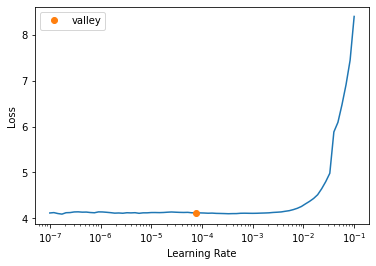

In [ ]:
tuner.lr_find()

It recommends a learning rate of around 5e-5, so we will use that.

In [ ]:
lr = 5e-5

Let's look at the documentation for `tune`:

In [ ]:
show_doc(LanguageModelTuner.tune)

<h4 id="AdaptiveTuner.tune" class="doc_header"><code>AdaptiveTuner.tune</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L369" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.tune</code>(**`epochs`**:`int`, **`lr`**:`float`=*`None`*, **`strategy`**:`Strategy`=*`'fit_one_cycle'`*, **`callbacks`**:`list`=*`[]`*, **\*\*`kwargs`**)

Fine tune `self.model` for `epochs` with an `lr` and `strategy`



We can pass in a number of epochs, a learning rate, a strategy, and additional fastai callbacks to call.

Valid strategies live in the `Strategy` namespace class, and consist of:
- OneCycle (Also called the [One-Cycle Policy](https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle))
- [CosineAnnealing](https://docs.fast.ai/callback.schedule.html#Learner.fit_flat_cos)
- [SGDR](https://docs.fast.ai/callback.schedule.html#Learner.fit_sgdr)

In [ ]:
from adaptnlp import Strategy

In this tutorial we will train with the One-Cycle policy, as currently it is one of the best schedulers to use.

In [ ]:
tuner.tune(3, lr, strategy=Strategy.OneCycle)

epoch,train_loss,valid_loss,perplexity,time
0,3.907161,3.809843,45.143364,31:15
1,3.814265,3.767976,43.292336,31:22
2,3.766881,3.760747,42.980507,31:02


## Saving Model

Now that we have a trained model, let's save those weights away.

Calling `tuner.save` will save both the model and the tokenizer in the same format as how HuggingFace does:

In [ ]:
show_doc(LanguageModelTuner.save)

<h4 id="AdaptiveTuner.save" class="doc_header"><code>AdaptiveTuner.save</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L391" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.save</code>(**`save_directory`**)

Save a pretrained model to a `save_directory`

**Function Arguments**:
* `save_directory`: A folder to save our model to


In [ ]:
tuner.save('good_model')

'good_model'

## Performing Inference

There are two ways to get predictions, the first is with the `.predict` method in our `tuner`. This is great for if you just finished training and want to see how your model performs on some new data!
The other method is with AdaptNLP's inference API, which we will show afterwards

### In Tuner

First let's write a sentence to test with

In [ ]:
sentence = "Hugh Jackman is a terrible"

And then predict with it:

In [ ]:
show_doc(LanguageModelTuner.predict)

<h4 id="LanguageModelTuner.predict" class="doc_header"><code>LanguageModelTuner.predict</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/language_model.py#L296" class="source_link" style="float:right">[source]</a></h4>

> <code>LanguageModelTuner.predict</code>(**`text`**:`Union`\[`List`\[`str`\], `str`\], **`bs`**:`int`=*`64`*, **`num_tokens_to_produce`**:`int`=*`50`*, **\*\*`kwargs`**)

Predict some `text` for sequence classification with the currently loaded model

**Function Arguments**:
* `text` (`Union[List[str], str]`): Some text or list of texts to do inference with
* `bs` (`int`): A batch size to use for multiple texts
* `num_tokens_to_produce` (`int`): Number of tokens to generate
* `**kwargs`: Optional arguments for `PretrainedModel.generate`


In [ ]:
tuner.predict(sentence, num_tokens_to_produce=13)

{'generated_text': ["Hugh Jackman is a terrible actor, and I'm not sure if he's a good actor"]}

### With the Inference API

Next we will use the `EasyTextGenerator` class, which AdaptNLP offers:

In [ ]:
from adaptnlp import EasyTextGenerator

We simply construct the class:

In [ ]:
classifier = EasyTextGenerator()

And call the `tag_text` method, passing in the sentence, the location of our saved model, and some names for our classes:

In [ ]:
classifier.generate(
    sentence,
    model_name_or_path='good_model',
    num_tokens_to_produce=13
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'generated_text': ["Hugh Jackman is a terrible actor, and I'm not sure if he's a good actor"]}

And we got the exact same output!